# Import libraries and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandasql as psql
from pandasql import sqldf

In [2]:
"""
define a function to read all the files
"""
def read_files(directory_path):
    data_files = []
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            if file.endswith('.csv'):
                data_files.append(os.path.join(root, file))
    
    data_objects = []
    for data_file in data_files:
        try:
            data_objects.append(pd.read_csv(data_file))
        except Exception as e:
            print(f"Error loading {data_file}: {e}")

    return data_objects

In [3]:
"""
reading the files and store them in a list of data frame
"""
base_directory_path = "/Users/hanweiyu/Downloads/data v2"
datas = read_files(base_directory_path)

# Clawing the website data

## Getting request

In [33]:
"""
Choosing the website:"https://www.moneydj.com/us/uslist/list0004#:~:text=URL%3A%20https%3A%2F%2Fwww" to claw.

What we need to do in this part is to get the companies' market code
and its annual benefit and variance and etc.

So, firstly, we should build the list of all the companies concluded by the transaction table.

And the claw the website and get information.

At last to map them together.

"""

import requests
from bs4 import BeautifulSoup

In [34]:
url = 'https://www.moneydj.com/us/uslist/list0004#:~:text=URL%3A%20https%3A%2F%2Fwww'

response = requests.get(url)
response.encoding = 'utf-8'

In [35]:
if response.status_code == 200:
    print("Success!")
    print(response.text[:500])
else:
    print(f"Fail, error code：{response.status_code}")

Success!

<!DOCTYPE html>
<html>
<meta HTTP-EQUIV="Content-Type" CONTENT="text/html; charset=UTF-8" />
<meta http-equiv="X-UA-Compatible" content="IE=edge" />
<head>

<title>美國行業成份股清單-美股-MoneyDJ理財網</title>
<meta name="description" content=提供您最新美股美國行業成份股清單，讓投資人作為投資參考依據，詳細介紹盡在MoneyDJ理財網美股。 />
<meta name="keywords" content="美國個股,美股指數,美國行業成份股清單,美股成份股清單,MoneyDJ理財網美股" />
<link rel="canonical" href="https://www.moneydj.com/us/uslist/list0004" />
<meta property="og:image" content="https://www.moneydj.


In [36]:
soup = BeautifulSoup(response.text, 'html.parser')

# the industry values are restored in this part
industry_select = soup.find('select', {'id': 'indexlist'})

options = industry_select.find_all('option') if industry_select else []

# build a dictionary to restore
industries = {option.text.strip(): option['value'] for option in options}

for industry, value in industries.items():
    print(f"Industry name: {industry}, Value: {value}")

Industry name: 水泥, Value: C9110000
Industry name: 食品飲料, Value: C9120000
Industry name: 石化, Value: C9130000
Industry name: 紡織, Value: C9140000
Industry name: 電機機械, Value: C9150000
Industry name: 電器電纜, Value: C9160000
Industry name: 化學工業, Value: C9170000
Industry name: 建材居家用品, Value: C9180000
Industry name: 造紙, Value: C9190000
Industry name: 鋼鐵金屬, Value: C9200000
Industry name: 車輛相關, Value: C9220000
Industry name: 電子, Value: C9230000
Industry name: 營建地產, Value: C9250000
Industry name: 運輸, Value: C9260000
Industry name: 觀光休閒娛樂, Value: C9270000
Industry name: 金融相關, Value: C9280000
Industry name: 百貨通路, Value: C9290000
Industry name: 公用事業, Value: C9300000
Industry name: 控股, Value: C9310000
Industry name: 生技醫療保健, Value: C9410000
Industry name: 初級產業, Value: C9420000
Industry name: 航天軍工, Value: C9430000
Industry name: 能源, Value: C9440000
Industry name: 傳播出版, Value: C9970000
Industry name: 綜合, Value: C9980000
Industry name: 傳產其他, Value: C9990000


In [38]:
Industries = list(industries)

## Clawing the information

In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
from selenium.common.exceptions import NoSuchElementException, StaleElementReferenceException

In [2]:
driver = webdriver.Safari()

try:
    url = 'https://www.moneydj.com/us/uslist/list0004#:~:text=URL%3A%20https%3A%2F%2Fwww'

    driver.get(url)

    WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.ID, "indexlist"))
    )

    industry_select = driver.find_element_by_id("indexlist")
    options = industry_select.find_elements_by_tag_name("option")

    whole_list = []

    for index, option in enumerate(options):
        industry_select = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.ID, "indexlist"))
        )
        options = industry_select.find_elements_by_tag_name("option")
        options[index].click()

        WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CLASS_NAME, "datalist"))
        )

        last_row_data = None

        while True:
            try:
                table = WebDriverWait(driver, 10).until(
                    EC.presence_of_element_located((By.CLASS_NAME, "datalist"))
                )
                rows = table.find_elements_by_css_selector("tr")
                
                current_last_row = rows[-1].text if rows else None

                if last_row_data == current_last_row:
                    break

                last_row_data = current_last_row

                for row in rows:
                    row_list = [options[index].text]
                    cols = row.find_elements_by_tag_name("td")
                    for col in cols:
                        row_list.append(col.text)
                    whole_list.append(row_list)

                next_button = driver.find_element_by_class_name("next")
                if next_button.is_enabled():
                    next_button.click()
                else:
                    break

            except NoSuchElementException:
                break
            except StaleElementReferenceException:
                continue

finally:
    driver.quit()

for data in whole_list:
    print(data)

/var/folders/pj/9y_1xfsd6hgdycw5q9sfcq5w0000gn/T/ipykernel_9108/2676463913.py:13: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  industry_select = driver.find_element_by_id("indexlist")
/opt/anaconda3/lib/python3.9/site-packages/selenium/webdriver/remote/webelement.py:359: UserWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  warnings.warn("find_elements_by_* commands are deprecated. Please use find_elements() instead")
/opt/anaconda3/lib/python3.9/site-packages/selenium/webdriver/remote/webelement.py:502: UserWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  warnings.warn("find_elements_by_* commands are deprecated. Please use find_elements() instead")
/var/folders/pj/9y_1xfsd6hgdycw5q9sfcq5w0000gn/T/ipykernel_9108/2676463913.py:58: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  next_button = driver.find

['水泥']
['水泥', '', 'CRH', 'CRH', '12/01', '64.4900', '4,566,594', '294,500', 'N/A', '0', '59.43', '29.94']
['水泥', '', 'MLM', 'Martin Marietta Materials Inc.', '12/01', '467.3500', '413,686', '193,336', '62', '29,023', '27.91', '24.69']
['水泥', '', 'VMC', 'Vulcan Materials', '12/01', '215.6300', '653,425', '140,898', '133', '28,657', '17.30', '23.45']
['水泥', '', 'SSD', 'Simpson Manufacturing', '12/01', '172.4900', '332,700', '57,387', '43', '7,361', '83.15', '42.59']
['水泥', '', 'CX', 'Cemex S.A.B. de C.V.', '12/01', '7.2000', '6,549,817', '47,159', 'N/A', '0', '60.36', '50.71']
['水泥', '', 'EXP', 'Eagle Materials Inc.', '12/01', '185.1300', '187,560', '34,723', '35', '6,485', '35.10', '30.98']
['水泥', '', 'KNF', 'Knife River', '12/01', '60.4600', '566,092', '34,226', '57', '3,420', 'N/A', 'N/A']
['水泥', '', 'SUM', 'Summit Materials', '12/01', '35.5500', '804,196', '28,589', '119', '4,234', '19.52', '41.02']
['水泥', '', 'MDU', 'MDU Resources', '12/01', '19.3100', '1,453,712', '28,071', '203', 

['電子', '', 'KAVL', 'Kaival Brands', '12/01', '0.2510', '158,383', '40', 'N/A', '0', '-75.87', '65.00']
['電子', '', 'TROO', 'TROOPS', '12/01', '2.8150', '14,358', '40', '102', '286', '38.67', '95.28']
['電子']
['電子', '', 'SPI', 'SPI Energy', '12/01', '0.6420', '62,730', '40', '30', '19', '-56.62', '122.03']
['電子', '', 'RFIL', 'RF Industries', '12/01', '2.7000', '14,628', '39', '10', '28', '-48.37', '27.75']
['電子', '', 'CLEU', 'China Liberal Education', '12/01', '0.1640', '236,704', '39', '32', '5', '-85.74', '146.40']
['電子', '', 'DSWL', 'Deswell Industries', '12/01', '2.6270', '14,626', '38', '16', '42', '-17.39', '26.33']
['電子', '', 'TAIT', 'Taitron Components', '12/01', '3.3600', '11,415', '38', '6', '20', '-7.69', '21.90']
['電子', '', 'SSNT', 'SilverSun Technologies', '12/01', '3.6700', '10,227', '38', '5', '19', '5.84', '38.56']
['電子', '', 'VISL', 'Vislink Technologies', '12/01', '4.0000', '9,324', '37', '2', '10', '-45.81', '103.90']
['電子', '', 'SANG', 'Sangoma', '12/01', '3.1500', '11

In [3]:
whole_list

[['水泥'],
 ['水泥',
  '',
  'CRH',
  'CRH',
  '12/01',
  '64.4900',
  '4,566,594',
  '294,500',
  'N/A',
  '0',
  '59.43',
  '29.94'],
 ['水泥',
  '',
  'MLM',
  'Martin Marietta Materials Inc.',
  '12/01',
  '467.3500',
  '413,686',
  '193,336',
  '62',
  '29,023',
  '27.91',
  '24.69'],
 ['水泥',
  '',
  'VMC',
  'Vulcan Materials',
  '12/01',
  '215.6300',
  '653,425',
  '140,898',
  '133',
  '28,657',
  '17.30',
  '23.45'],
 ['水泥',
  '',
  'SSD',
  'Simpson Manufacturing',
  '12/01',
  '172.4900',
  '332,700',
  '57,387',
  '43',
  '7,361',
  '83.15',
  '42.59'],
 ['水泥',
  '',
  'CX',
  'Cemex S.A.B. de C.V.',
  '12/01',
  '7.2000',
  '6,549,817',
  '47,159',
  'N/A',
  '0',
  '60.36',
  '50.71'],
 ['水泥',
  '',
  'EXP',
  'Eagle Materials Inc.',
  '12/01',
  '185.1300',
  '187,560',
  '34,723',
  '35',
  '6,485',
  '35.10',
  '30.98'],
 ['水泥',
  '',
  'KNF',
  'Knife River',
  '12/01',
  '60.4600',
  '566,092',
  '34,226',
  '57',
  '3,420',
  'N/A',
  'N/A'],
 ['水泥',
  '',
  'SUM',
  'Su

In [4]:
length = 12

In [5]:
whole_list = [whole_list[i] for i in range(len(whole_list)) if len(whole_list[i]) == length]

In [6]:
import pandas as pd
stock = pd.DataFrame(whole_list)

In [8]:
stock = stock.iloc[:,[0,2,3,4,5,6,7,8,9,10,11]]

In [9]:
stock

,0,2,3,4,5,6,7,8,9,10,11
0,水泥,CRH,CRH,12/01,64.4900,"4,566,594","294,500",N/A,0,59.43,29.94
1,水泥,MLM,Martin Marietta Materials Inc.,12/01,467.3500,"413,686","193,336",62,"29,023",27.91,24.69
2,水泥,VMC,Vulcan Materials,12/01,215.6300,"653,425","140,898",133,"28,657",17.30,23.45
3,水泥,SSD,Simpson Manufacturing,12/01,172.4900,"332,700","57,387",43,"7,361",83.15,42.59
4,水泥,CX,Cemex S.A.B. de C.V.,12/01,7.2000,"6,549,817","47,159",N/A,0,60.36,50.71
...,...,...,...,...,...,...,...,...,...,...,...
3417,傳產其他,JCI,Johnson Controls,12/01,53.8900,"4,526,087","243,911",680,"36,662",-19.45,27.44
3418,傳產其他,ASO,Academy Sports and Outdoors,12/01,55.1700,"4,373,158","241,267",74,"4,091",11.50,43.55
3419,傳產其他,IT,Gartner,12/01,441.1400,"532,043","234,705",79,"34,671",23.82,37.34
3420,傳產其他,GWW,W.W. Grainger,12/01,803.5800,"281,450","226,168",50,"39,955",33.22,30.05


In [10]:
industry_mapping = {
    "水泥": "Cement",
    "食品飲料": "Food & Beverage",
    "石化": "Petrochemical",
    "紡織": "Textile",
    "電機機械": "Electrical Machinery",
    "電器電纜": "Electrical Appliances and Cables",
    "化學工業": "Chemical Industry",
    "建材居家用品": "Building Materials & Home Furnishings",
    "造紙": "Papermaking",
    "鋼鐵金屬": "Steel & Metal",
    "車輛相關": "Vehicle Related",
    "電子": "Electronics",
    "營建地產": "Construction & Real Estate",
    "運輸": "Transportation",
    "觀光休閒娛樂": "Tourism, Leisure & Entertainment",
    "金融相關": "Financial Related",
    "百貨通路": "Department Stores & Channels",
    "公用事業": "Public Utilities",
    "控股": "Holdings",
    "生技醫療保健": "Biotechnology & Healthcare",
    "初級產業": "Primary Industry",
    "航天軍工": "Aerospace & Military",
    "能源": "Energy",
    "傳播出版": "Communication & Publishing",
    "綜合": "Comprehensive",
    "傳產其他": "Other Traditional Industries"
}

In [13]:
stock.iloc[:,0] = stock.iloc[:,0].map(industry_mapping)

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


In [14]:
stock

,0,2,3,4,5,6,7,8,9,10,11
0,Cement,CRH,CRH,12/01,64.4900,"4,566,594","294,500",N/A,0,59.43,29.94
1,Cement,MLM,Martin Marietta Materials Inc.,12/01,467.3500,"413,686","193,336",62,"29,023",27.91,24.69
2,Cement,VMC,Vulcan Materials,12/01,215.6300,"653,425","140,898",133,"28,657",17.30,23.45
3,Cement,SSD,Simpson Manufacturing,12/01,172.4900,"332,700","57,387",43,"7,361",83.15,42.59
4,Cement,CX,Cemex S.A.B. de C.V.,12/01,7.2000,"6,549,817","47,159",N/A,0,60.36,50.71
...,...,...,...,...,...,...,...,...,...,...,...
3417,Other Traditional Industries,JCI,Johnson Controls,12/01,53.8900,"4,526,087","243,911",680,"36,662",-19.45,27.44
3418,Other Traditional Industries,ASO,Academy Sports and Outdoors,12/01,55.1700,"4,373,158","241,267",74,"4,091",11.50,43.55
3419,Other Traditional Industries,IT,Gartner,12/01,441.1400,"532,043","234,705",79,"34,671",23.82,37.34
3420,Other Traditional Industries,GWW,W.W. Grainger,12/01,803.5800,"281,450","226,168",50,"39,955",33.22,30.05


In [17]:
stock_col = ['Industry', 'Code', 'Name', 'Date', 'Price', 'Trade Volumn',
            'Trade Value(kilo)', 'Num of Stock(million)', 'Value(million)',
            'Annual Profit', 'Std']

In [18]:
stock.columns = stock_col

In [24]:
stock.to_csv("../data/stock.csv")

In [19]:
stock_info = stock.iloc[:,[0,1,9,10]]

In [20]:
stock_info.head()

,Industry,Code,Annual Profit,Std
0,Cement,CRH,59.43,29.94
1,Cement,MLM,27.91,24.69
2,Cement,VMC,17.30,23.45
3,Cement,SSD,83.15,42.59
4,Cement,CX,60.36,50.71


# User investment income

In [9]:
"""
Assume there are 252 trasction days in one year.

"""

transactions = datas[0].reset_index(drop=True)


sql_query = """

WITH 
-- 计算每位用户的首次交易日期
FirstTradeDate AS (
  SELECT identifier, MIN(DATE(trade_order_level_filled_at)) AS first_trade_date
  FROM transactions
  GROUP BY identifier
),
-- 计算日均收益
DailyProfit AS (
  SELECT identifier,
         SUM(CASE WHEN side = 'sell' THEN trade_value_usd ELSE -trade_value_usd END) / COUNT(DISTINCT DATE(trade_order_level_filled_at)) AS avg_daily_profit
  FROM transactions
  GROUP BY identifier
),
-- 计算总收益额和总收益率
TotalProfit AS (
  SELECT identifier,
         SUM(CASE WHEN side = 'sell' THEN trade_value_usd ELSE -trade_value_usd END) AS total_profit,
         (SUM(CASE WHEN side = 'sell' THEN trade_value_usd ELSE -trade_value_usd END) / NULLIF(SUM(CASE WHEN side = 'buy' THEN trade_value_usd ELSE 0 END), 0)) * 100 AS total_profit_rate
  FROM transactions
  GROUP BY identifier
),
-- 计算前三笔交易的收益额和收益率
FirstThreeTrades AS (
  SELECT identifier,
         SUM(CASE WHEN side = 'sell' THEN trade_value_usd ELSE -trade_value_usd END) AS profit_first_three_trades,
         (SUM(CASE WHEN side = 'sell' THEN trade_value_usd ELSE -trade_value_usd END) / NULLIF(SUM(CASE WHEN side = 'buy' THEN trade_value_usd ELSE 0 END), 0)) * 100 AS profit_rate_first_three_trades
  FROM (SELECT *, ROW_NUMBER() OVER (PARTITION BY identifier ORDER BY trade_order_level_filled_at) as rn FROM transactions)
  WHERE rn <= 3
  GROUP BY identifier
),
-- 计算第一笔交易往后7天的收益额和收益率
ProfitAfterFirstTrade7D AS (
  SELECT t.identifier,
         SUM(CASE WHEN t.side = 'sell' THEN t.trade_value_usd ELSE -t.trade_value_usd END) AS profit_after_first_trade_7d,
         (SUM(CASE WHEN t.side = 'sell' THEN t.trade_value_usd ELSE -t.trade_value_usd END) / NULLIF(SUM(CASE WHEN t.side = 'buy' THEN t.trade_value_usd ELSE 0 END), 0)) * 100 AS profit_rate_after_first_trade_7d
  FROM transactions t
  JOIN FirstTradeDate f ON t.identifier = f.identifier
  WHERE DATE(t.trade_order_level_filled_at) BETWEEN f.first_trade_date AND DATE(f.first_trade_date, '+6 days')
  GROUP BY t.identifier
),
-- 计算第一笔交易往后14天的收益额和收益率
ProfitAfterFirstTrade14D AS (
  SELECT t.identifier,
         SUM(CASE WHEN t.side = 'sell' THEN t.trade_value_usd ELSE -t.trade_value_usd END) AS profit_after_first_trade_14d,
         (SUM(CASE WHEN t.side = 'sell' THEN t.trade_value_usd ELSE -t.trade_value_usd END) / NULLIF(SUM(CASE WHEN t.side = 'buy' THEN t.trade_value_usd ELSE 0 END), 0)) * 100 AS profit_rate_after_first_trade_14d
  FROM transactions t
  JOIN FirstTradeDate f ON t.identifier = f.identifier
  WHERE DATE(t.trade_order_level_filled_at) BETWEEN f.first_trade_date AND DATE(f.first_trade_date, '+13 days')
  GROUP BY t.identifier
),
-- 计算第一笔交易往后30天的收益额和收益率
ProfitAfterFirstTrade30D AS (
  SELECT t.identifier,
         SUM(CASE WHEN t.side = 'sell' THEN t.trade_value_usd ELSE -t.trade_value_usd END) AS profit_after_first_trade_30d,
         (SUM(CASE WHEN t.side = 'sell' THEN t.trade_value_usd ELSE -t.trade_value_usd END) / NULLIF(SUM(CASE WHEN t.side = 'buy' THEN t.trade_value_usd ELSE 0 END), 0)) * 100 AS profit_rate_after_first_trade_30d
  FROM transactions t
  JOIN FirstTradeDate f ON t.identifier = f.identifier
  WHERE DATE(t.trade_order_level_filled_at) BETWEEN f.first_trade_date AND DATE(f.first_trade_date, '+29 days')
  GROUP BY t.identifier
),
-- 计算第一笔交易往后60天的收益额和收益率
ProfitAfterFirstTrade60D AS (
  SELECT t.identifier,
         SUM(CASE WHEN t.side = 'sell' THEN t.trade_value_usd ELSE -t.trade_value_usd END) AS profit_after_first_trade_60d,
         (SUM(CASE WHEN t.side = 'sell' THEN t.trade_value_usd ELSE -t.trade_value_usd END) / NULLIF(SUM(CASE WHEN t.side = 'buy' THEN t.trade_value_usd ELSE 0 END), 0)) * 100 AS profit_rate_after_first_trade_60d
  FROM transactions t
  JOIN FirstTradeDate f ON t.identifier = f.identifier
  WHERE DATE(t.trade_order_level_filled_at) BETWEEN f.first_trade_date AND DATE(f.first_trade_date, '+59 days')
  GROUP BY t.identifier
)


SELECT 
  ft.identifier,
  dp.avg_daily_profit,
  tp.total_profit,
  tp.total_profit_rate,
  ftt.profit_first_three_trades,
  ftt.profit_rate_first_three_trades,
  pft7d.profit_after_first_trade_7d,
  pft7d.profit_rate_after_first_trade_7d,
  pft14d.profit_after_first_trade_14d,
  pft14d.profit_rate_after_first_trade_14d,
  pft30d.profit_after_first_trade_30d,
  pft30d.profit_rate_after_first_trade_30d,
  pft60d.profit_after_first_trade_60d,
  pft60d.profit_rate_after_first_trade_60d
  
FROM 
  FirstTradeDate ft
LEFT JOIN DailyProfit dp ON ft.identifier = dp.identifier
LEFT JOIN TotalProfit tp ON ft.identifier = tp.identifier
LEFT JOIN FirstThreeTrades ftt ON ft.identifier = ftt.identifier
LEFT JOIN ProfitAfterFirstTrade7D pft7d ON ft.identifier = pft7d.identifier
LEFT JOIN ProfitAfterFirstTrade14D pft14d ON ft.identifier = pft14d.identifier
LEFT JOIN ProfitAfterFirstTrade30D pft30d ON ft.identifier = pft30d.identifier
LEFT JOIN ProfitAfterFirstTrade60D pft60d ON ft.identifier = pft60d.identifier


"""

invest_income = psql.sqldf(sql_query, locals())

In [10]:
invest_income

,identifier,avg_daily_profit,total_profit,total_profit_rate,profit_first_three_trades,profit_rate_first_three_trades,profit_after_first_trade_7d,profit_rate_after_first_trade_7d,profit_after_first_trade_14d,profit_rate_after_first_trade_14d,profit_after_first_trade_30d,profit_rate_after_first_trade_30d,profit_after_first_trade_60d,profit_rate_after_first_trade_60d
0,1,-7.440000,-14.880000,-74.849095,-14.880000,-74.849095,-10.000000,-100.000000,-14.880000,-74.849095,-14.880000,-74.849095,-14.880000,-74.849095
1,2,-4.048137,-20.240687,-79.053147,-8.279900,-100.000000,-18.027898,-94.744559,-18.027898,-94.744559,-18.027898,-94.744559,-18.027898,-94.744559
2,3,-2.009985,-10.049926,-26.103704,-14.839999,-100.000000,-14.839999,-100.000000,-14.839999,-100.000000,-21.826258,-88.293929,-23.706258,-82.889019
3,4,1.452898,5.811591,18.003691,-4.860551,-32.930563,0.019449,0.196850,0.019449,0.196850,-12.624573,-46.075087,-10.555632,-32.700223
4,5,-11.461464,-68.768784,-90.200399,-14.760000,-74.696357,-4.880000,-49.392714,-13.760000,-69.635628,-13.760000,-69.635628,-13.760000,-69.635628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2570,2696,-1474.565426,-5898.261705,-95.805964,-30.000000,-100.000000,-2006.275607,-88.597630,-5898.261705,-95.805964,-5898.261705,-95.805964,-5898.261705,-95.805964
2571,2697,-15.620000,-15.620000,-100.000000,-15.620000,-100.000000,-15.620000,-100.000000,-15.620000,-100.000000,-15.620000,-100.000000,-15.620000,-100.000000
2572,2698,-56.678749,-170.036248,-30.969659,-414.128400,-100.000000,-413.938906,-97.384008,-170.036248,-30.969659,-170.036248,-30.969659,-170.036248,-30.969659
2573,2699,-14.940000,-14.940000,-100.000000,-14.940000,-100.000000,-14.940000,-100.000000,-14.940000,-100.000000,-14.940000,-100.000000,-14.940000,-100.000000


In [18]:
neg = invest_income[invest_income['total_profit_rate'] <= 0]

In [19]:
# 1724 of 2575 users' profit rate is negative 
neg[neg['total_profit_rate'] != -100].shape

(1724, 14)

In [13]:
invest_income['total_profit_rate'].max()

89.733186782675

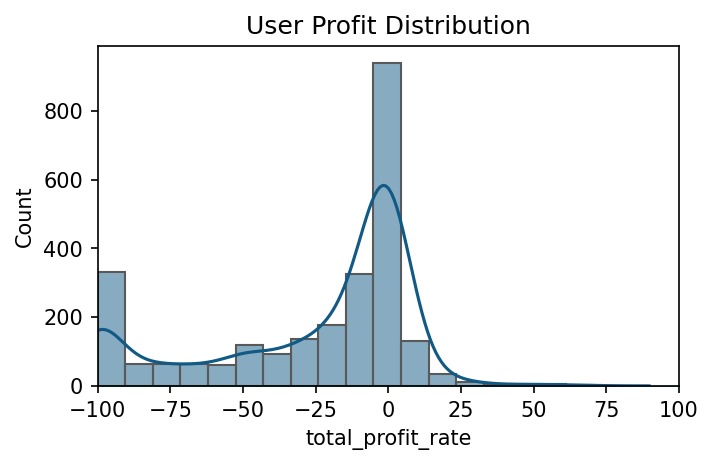

In [45]:
plt.figure(figsize=(5,3), dpi=150)
sns.histplot(invest_income['total_profit_rate'], bins=20, kde=True,
             color = "#105a85", edgecolor = "#595959", linewidth=1)
sns.kdeplot(invest_income['total_profit_rate'], color="#3c96b4", lw=0.7, fill=True)

plt.title('User Profit Distribution')
plt.xlim(-100,100)

plt.show()

In [14]:
invest_income.to_csv("../data/invest_income.csv")

# User investment preference

In [46]:
stock = pd.read_csv("../data/stock.csv")

In [49]:
stock_info = stock.iloc[:,[1,2,10,11]]

In [50]:
stock_info.head()

,Industry,Code,Annual Profit,Std
0,Cement,CRH,59.43,29.94
1,Cement,MLM,27.91,24.69
2,Cement,VMC,17.30,23.45
3,Cement,SSD,83.15,42.59
4,Cement,CX,60.36,50.71


In [71]:
industry = stock_info

sql_query = """

WITH IndustryLeaders AS (
    SELECT Code, Industry
    FROM (
        SELECT Code, Industry,
               PERCENT_RANK() OVER (PARTITION BY Industry ORDER BY "Annual Profit" DESC) AS ProfitRank
        FROM stock_info
    )
    WHERE ProfitRank <= 0.1
),
UserInvestment AS (
    SELECT identifier, SUM(trade_value_usd) AS TotalInvestment
    FROM transactions
    GROUP BY identifier
),
LeaderInvestment AS (
    SELECT t.identifier, SUM(t.trade_value_usd) AS LeaderInvestment
    FROM transactions t
    JOIN IndustryLeaders l ON t.symbol = l.Code
    GROUP BY t.identifier
),
InvestmentRatios AS (
    SELECT
        u.identifier,
        u.TotalInvestment,
        IFNULL(l.LeaderInvestment, 0) AS LeaderInvestment,
        IFNULL(l.LeaderInvestment, 0) / u.TotalInvestment AS LeaderInvestmentRatio
    FROM UserInvestment u
    LEFT JOIN LeaderInvestment l ON u.identifier = l.identifier
),
IndustryInvestment AS (
    SELECT t.identifier, i.Industry, SUM(t.trade_value_usd) as TotalInvestment
    FROM transactions t
    LEFT JOIN stock_info i ON t.symbol = i.Code
    GROUP BY t.identifier, i.Industry
),
RankedIndustries AS (
    SELECT identifier, Industry, TotalInvestment,
           ROW_NUMBER() OVER (PARTITION BY identifier ORDER BY TotalInvestment DESC, Industry) as RowNum
    FROM IndustryInvestment
),
InvestmentCounts AS (
    SELECT identifier, 
           COUNT(DISTINCT symbol) AS TotalCompanies,
           COUNT(DISTINCT Industry) AS TotalIndustries
    FROM transactions t
    LEFT JOIN stock_info i ON t.symbol = i.Code
    GROUP BY identifier
),
HighRiskCompanies AS (
    SELECT t.identifier, 
           CAST(SUM(CASE WHEN i.Std > (SELECT MAX(Std) FROM stock_info) * 0.75 THEN 1 ELSE 0 END) AS FLOAT) / COUNT(DISTINCT t.symbol) as HighRiskRatio
    FROM transactions t
    LEFT JOIN stock_info i ON t.symbol = i.Code
    GROUP BY t.identifier
)

SELECT 
    a.identifier,
    b.Industry as Top1_Industry,
    c.Industry as Top2_Industry,
    d.Industry as Top3_Industry,
    e.TotalCompanies,
    e.TotalIndustries,
    f.HighRiskRatio,
    COALESCE(g.LeaderInvestmentRatio, 0) as LeaderInvestmentRatio
FROM 
    (SELECT DISTINCT identifier FROM transactions) a
LEFT JOIN RankedIndustries b ON a.identifier = b.identifier AND b.RowNum = 1
LEFT JOIN RankedIndustries c ON a.identifier = c.identifier AND c.RowNum = 2
LEFT JOIN RankedIndustries d ON a.identifier = d.identifier AND d.RowNum = 3
LEFT JOIN InvestmentCounts e ON a.identifier = e.identifier
LEFT JOIN HighRiskCompanies f ON a.identifier = f.identifier
LEFT JOIN InvestmentRatios g ON a.identifier = g.identifier
GROUP BY a.identifier, e.TotalCompanies, e.TotalIndustries, f.HighRiskRatio, g.LeaderInvestmentRatio



"""

invest_prefer = psql.sqldf(sql_query, locals())

In [72]:
invest_prefer

,identifier,Top1_Industry,Top2_Industry,Top3_Industry,TotalCompanies,TotalIndustries,HighRiskRatio,LeaderInvestmentRatio
0,1,Electronics,None,None,1,1,0.000000,0.000000
1,2,Electronics,None,"Tourism, Leisure & Entertainment",7,5,0.000000,0.000000
2,3,Electronics,None,Aerospace & Military,4,4,0.000000,0.000000
3,4,Electronics,None,None,2,1,0.000000,0.000000
4,5,Biotechnology & Healthcare,Chemical Industry,Financial Related,5,6,0.200000,0.011946
...,...,...,...,...,...,...,...,...
2570,2696,Vehicle Related,Other Traditional Industries,Electronics,14,7,1.714286,0.000000
2571,2697,Electronics,None,None,1,1,0.000000,0.000000
2572,2698,Electronics,Aerospace & Military,Energy,2,4,12.000000,0.000000
2573,2699,Electronics,None,None,1,1,0.000000,0.000000


In [77]:
ind_dis = invest_prefer[invest_income['total_profit_rate'] >= 0]['Top1_Industry']
ind_dis.value_counts()

Electronics                     450
Aerospace & Military             36
Financial Related                24
Vehicle Related                  23
Biotechnology & Healthcare       14
Food & Beverage                   3
Energy                            3
Communication & Publishing        2
Other Traditional Industries      2
Primary Industry                  2
Chemical Industry                 1
Name: Top1_Industry, dtype: int64

In [79]:
neg_ind_dis = invest_prefer[invest_income['total_profit_rate'] < 50]['Top1_Industry']
neg_ind_dis.value_counts()

Electronics                         1992
Aerospace & Military                 122
Financial Related                     90
Biotechnology & Healthcare            77
Vehicle Related                       66
Food & Beverage                       26
Energy                                15
Communication & Publishing            12
Primary Industry                      11
Chemical Industry                     11
Other Traditional Industries           3
Department Stores & Channels           2
Holdings                               2
Textile                                1
Tourism, Leisure & Entertainment       1
Electrical Machinery                   1
Name: Top1_Industry, dtype: int64

In [73]:
invest_prefer.to_csv("../data/invest_prefer.csv")

# User behaviour key measurement

In [12]:
trades = datas[0]
accounts = datas[1]
deposits = datas[2]
churn_status = datas[3]
kyc = datas[5]

sql_query = """

WITH RankedTrades AS (
  SELECT *,
         ROW_NUMBER() OVER (PARTITION BY identifier ORDER BY trade_order_level_filled_at) AS rn,
         COUNT(*) OVER (PARTITION BY identifier) AS total_trades
  FROM trades
),
FirstLastTrades AS (
  SELECT 
    identifier,
    MIN(CASE WHEN rn = 1 THEN trade_order_level_filled_at END) AS first_trade_at,
    MIN(CASE WHEN rn = 2 THEN trade_order_level_filled_at END) AS second_trade_at,
    MIN(CASE WHEN rn = 3 THEN trade_order_level_filled_at END) AS third_trade_at,
    MIN(CASE WHEN rn = 7 THEN trade_order_level_filled_at END) AS seventh_trade_at,
    MAX(CASE WHEN rn = total_trades THEN trade_order_level_filled_at END) AS last_trade_at
  FROM RankedTrades
  GROUP BY identifier
),
FirstTradeDate AS (
  SELECT identifier, MIN(trade_order_level_filled_at) AS first_trade_date
  FROM trades
  GROUP BY identifier
),
TotalVolumes AS (
  SELECT identifier, SUM(qty) AS total_qty, SUM(trade_value_usd) AS total_trade_value
  FROM trades
  GROUP BY identifier
)

SELECT 
  a.identifier,
  julianday('2023-08-29') - julianday(MAX(tr.trade_order_level_filled_at)) AS days_since_last_trade,
  COUNT(tr.identifier) AS recent_trade_count,
  SUM(tr.trade_value_usd) AS recent_trade_total_value,
  MAX(ch.is_churn) AS churn_status,
  
  (
  SELECT 
    SUM(CASE WHEN ch.is_churn = 0 THEN tr.qty ELSE 0 END) 
  FROM churn_status ch
  WHERE ch.identifier = a.identifier
) / NULLIF(SUM(tr.qty), 0) AS trade_volume_pre_churn_ratio,
(
  SELECT 
    SUM(CASE WHEN ch.is_churn = 0 THEN tr.trade_value_usd ELSE 0 END)
  FROM churn_status ch
  WHERE ch.identifier = a.identifier
) / NULLIF(SUM(tr.trade_value_usd), 0) AS trade_value_pre_churn_ratio,


  SUM(CASE WHEN julianday(tr.trade_order_level_filled_at) <= julianday(a.account_opened_at) + 1 THEN tr.qty ELSE 0 END) / NULLIF(SUM(tr.qty), 0) AS volume_day_1_ratio,
  SUM(CASE WHEN julianday(tr.trade_order_level_filled_at) <= julianday(a.account_opened_at) + 3 THEN tr.qty ELSE 0 END) / NULLIF(SUM(tr.qty), 0) AS volume_day_3_ratio,
  SUM(CASE WHEN julianday(tr.trade_order_level_filled_at) <= julianday(a.account_opened_at) + 7 THEN tr.qty ELSE 0 END) / NULLIF(SUM(tr.qty), 0) AS volume_day_7_ratio,
  SUM(CASE WHEN julianday(tr.trade_order_level_filled_at) <= julianday(a.account_opened_at) + 14 THEN tr.qty ELSE 0 END) / NULLIF(SUM(tr.qty), 0) AS volume_day_14_ratio,

  -- Similar for trade_value_usd
  SUM(CASE WHEN julianday(tr.trade_order_level_filled_at) <= julianday(a.account_opened_at) + 1 THEN tr.trade_value_usd ELSE 0 END) / NULLIF(SUM(tr.trade_value_usd), 0) AS value_day_1_ratio,
  SUM(CASE WHEN julianday(tr.trade_order_level_filled_at) <= julianday(a.account_opened_at) + 3 THEN tr.trade_value_usd ELSE 0 END) / NULLIF(SUM(tr.trade_value_usd), 0) AS value_day_3_ratio,
  SUM(CASE WHEN julianday(tr.trade_order_level_filled_at) <= julianday(a.account_opened_at) + 7 THEN tr.trade_value_usd ELSE 0 END) / NULLIF(SUM(tr.trade_value_usd), 0) AS value_day_7_ratio,
  SUM(CASE WHEN julianday(tr.trade_order_level_filled_at) <= julianday(a.account_opened_at) + 14 THEN tr.trade_value_usd ELSE 0 END) / NULLIF(SUM(tr.trade_value_usd), 0) AS value_day_14_ratio,


  SUM(CASE WHEN julianday(tr.trade_order_level_filled_at) <= julianday(ftd.first_trade_date) + 1 THEN tr.qty ELSE 0 END) / tv.total_qty AS volume_after_first_trade_1d_ratio,
  SUM(CASE WHEN julianday(tr.trade_order_level_filled_at) <= julianday(ftd.first_trade_date) + 3 THEN tr.qty ELSE 0 END) / tv.total_qty AS volume_after_first_trade_3d_ratio,
  SUM(CASE WHEN julianday(tr.trade_order_level_filled_at) <= julianday(ftd.first_trade_date) + 7 THEN tr.qty ELSE 0 END) / tv.total_qty AS volume_after_first_trade_7d_ratio,
  SUM(CASE WHEN julianday(tr.trade_order_level_filled_at) <= julianday(ftd.first_trade_date) + 14 THEN tr.qty ELSE 0 END) / tv.total_qty AS volume_after_first_trade_14d_ratio,
  
  SUM(CASE WHEN julianday(tr.trade_order_level_filled_at) <= julianday(ftd.first_trade_date) + 1 THEN tr.trade_value_usd ELSE 0 END) / NULLIF(SUM(tr.trade_value_usd), 0) AS value_after_first_trade_1d_ratio,
  SUM(CASE WHEN julianday(tr.trade_order_level_filled_at) <= julianday(ftd.first_trade_date) + 3 THEN tr.trade_value_usd ELSE 0 END) / NULLIF(SUM(tr.trade_value_usd), 0) AS value_after_first_trade_3d_ratio,
  SUM(CASE WHEN julianday(tr.trade_order_level_filled_at) <= julianday(ftd.first_trade_date) + 7 THEN tr.trade_value_usd ELSE 0 END) / NULLIF(SUM(tr.trade_value_usd), 0) AS value_after_first_trade_7d_ratio,
  SUM(CASE WHEN julianday(tr.trade_order_level_filled_at) <= julianday(ftd.first_trade_date) + 14 THEN tr.trade_value_usd ELSE 0 END) / NULLIF(SUM(tr.trade_value_usd), 0) AS value_after_first_trade_14d_ratio,
  
  julianday(a.account_opened_at) - julianday(k.kyc_started_at) AS days_account_to_kyc,
  julianday(a.account_opened_at) - julianday((SELECT MIN(deposit_paid_at) FROM deposits WHERE identifier = a.identifier)) AS days_account_to_first_deposit,
  julianday((SELECT MIN(deposit_paid_at) FROM deposits WHERE identifier = a.identifier)) - julianday(k.kyc_started_at) AS days_first_deposit_to_kyc,
  julianday(k.kyc_started_at) - julianday(flt.first_trade_at) AS days_kyc_to_first_trade,
  julianday(flt.first_trade_at) - julianday(flt.second_trade_at) AS days_first_to_second_trade,
  julianday(flt.first_trade_at) - julianday(flt.third_trade_at) AS days_first_to_third_trade,
  julianday(flt.first_trade_at) - julianday(flt.seventh_trade_at) AS days_first_to_seventh_trade,
  julianday(flt.first_trade_at) - julianday(flt.last_trade_at) AS days_first_to_last_trade,
  julianday(a.account_opened_at) - julianday((SELECT MAX(churn_status_tracked_at) FROM churn_status WHERE identifier = a.identifier AND is_churn = 1)) AS days_to_churn,
  julianday((SELECT MIN(deposit_paid_at) FROM deposits WHERE identifier = a.identifier)) - julianday((SELECT MAX(churn_status_tracked_at) FROM churn_status WHERE identifier = a.identifier AND is_churn = 1)) AS days_first_deposit_to_churn,
  julianday(k.kyc_started_at) - julianday((SELECT MAX(churn_status_tracked_at) FROM churn_status WHERE identifier = a.identifier AND is_churn = 1)) AS days_kyc_to_churn
FROM 
  accounts a
LEFT JOIN trades tr ON a.identifier = tr.identifier AND tr.trade_order_level_filled_at > DATE('2023-08-29', '-1 month')
LEFT JOIN churn_status ch ON a.identifier = ch.identifier
LEFT JOIN kyc k ON a.identifier = k.identifier
LEFT JOIN FirstTradeDate ftd ON a.identifier = ftd.identifier
LEFT JOIN FirstLastTrades flt ON a.identifier = flt.identifier
LEFT JOIN TotalVolumes tv ON a.identifier = tv.identifier
GROUP BY 
  a.identifier


"""

user_behaviour = psql.sqldf(sql_query, locals())

In [13]:
user_behaviour

,identifier,days_since_last_trade,recent_trade_count,recent_trade_total_value,churn_status,trade_volume_pre_churn_ratio,trade_value_pre_churn_ratio,volume_day_1_ratio,volume_day_3_ratio,volume_day_7_ratio,...,days_account_to_first_deposit,days_first_deposit_to_kyc,days_kyc_to_first_trade,days_first_to_second_trade,days_first_to_third_trade,days_first_to_seventh_trade,days_first_to_last_trade,days_to_churn,days_first_deposit_to_churn,days_kyc_to_churn
0,1,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,...,-88.416146,88.504132,-54.610428,-6.923924,-6.924294,NaN,-6.924294,NaN,NaN,NaN
1,2,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,...,0.139954,1.062234,-1.254525,-0.000498,-0.020324,-0.104722,-445.836053,NaN,NaN,NaN
2,3,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,...,0.089780,1.015069,-1.157269,-0.015984,-0.020312,-40.964271,-541.910197,NaN,NaN,NaN
3,4,21.437488,1158,9476.622178,0,0.440821,0.661261,0.000000,0.000000,0.000000,...,0.521053,0.559641,-4.071794,-0.003345,-25.008437,-37.019282,-552.958322,NaN,NaN,NaN
4,5,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,...,0.202801,0.021968,-11.156389,-0.000567,-12.013553,-418.024838,-453.946817,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2695,2696,0.353808,480,64146.704858,0,0.000441,0.001559,0.000000,0.346837,0.629163,...,0.017847,0.102685,-1.276273,0.000000,-0.000012,-0.097014,-7.083692,NaN,NaN,NaN
2696,2697,7.437500,10,156.199999,0,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.019595,0.006238,-0.889896,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
2697,2698,-0.617153,81,8352.418962,0,0.015182,0.011853,0.015182,0.515179,0.515179,...,0.016794,0.008785,-0.264676,-1.011181,-1.065856,-8.028819,-8.054641,NaN,NaN,NaN
2698,2699,6.437477,9,134.460000,0,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.013704,0.038380,-1.002951,NaN,NaN,NaN,0.000000,NaN,NaN,NaN


In [15]:
user_behaviour.to_csv("../data/user_behaviour.csv")